### Validation for 2020-08-28 onboarding customer score run
---

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
# from train import features, preprocess, encode_defaults, default_values
from src.utils import scale_scores
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

### Data Preprocessing

In [2]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 'giact_time_since_last_link', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [3]:
# get scores
model = pkl.load(open('../../models/customer_risk_target_from_gitlab.pkl', 'rb'))

In [4]:
# production data
# prod_path = '../../data-production/2020-08-28_onboarding-customer-model-data.csv'
# prod_path = '../../data-production/2020'
# prod_df = pd.read_csv(prod_path, index_col=0)
prod_df = pkl.load(open('../../data-production/2020-09-01_full-customer-model-data.pickle', 'rb'))
prod_df['model_score'] = prod_df.model_score.astype(float)
prod_df['created_dt'] = pd.to_datetime(prod_df.created_dt)

# pred and scores get from dev model
prod_df['dev_pred'] = model.predict_proba(prod_df[features])[:, 1]
prod_df['dev_score'] = scale_scores(prod_df['dev_pred'])

In [5]:
# # dev data from dw
modeling_df = pd.read_feather('../../data/combined_all_features/combined_1599599721.feather')
modeling_df, _ = encode_defaults(modeling_df, default_values)
modeling_df = modeling_df[modeling_df.is_static]
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']
modeling_df = modeling_df[modeling_df.sample_date == pd.to_datetime('2020-08-31')]
modeling_df = preprocess(modeling_df)
modeling_df['pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['score'] = scale_scores(modeling_df['pred'])

### EDA on dfs

In [6]:
# trim dfs
id_dict = get_overlap_and_diff(modeling_df.party_id, prod_df.party_id)
shared_id = id_dict['shared']

<AxesSubplot:>

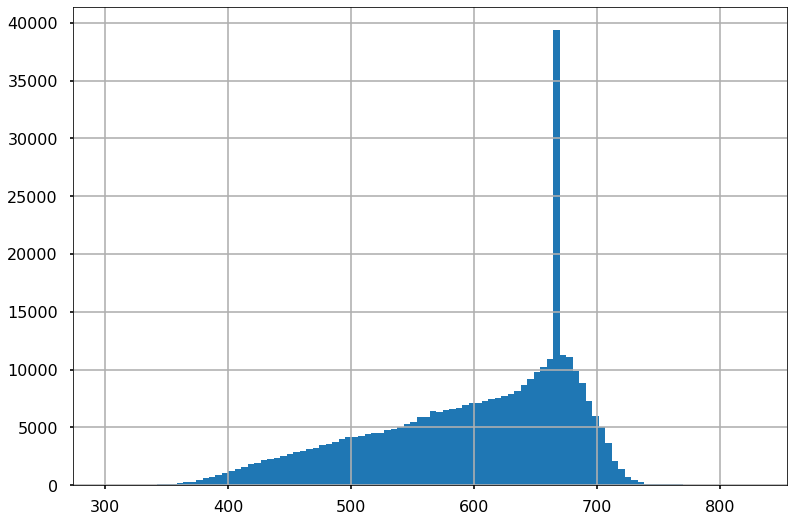

In [7]:
prod_df.dev_score.hist(bins=100)

<AxesSubplot:>

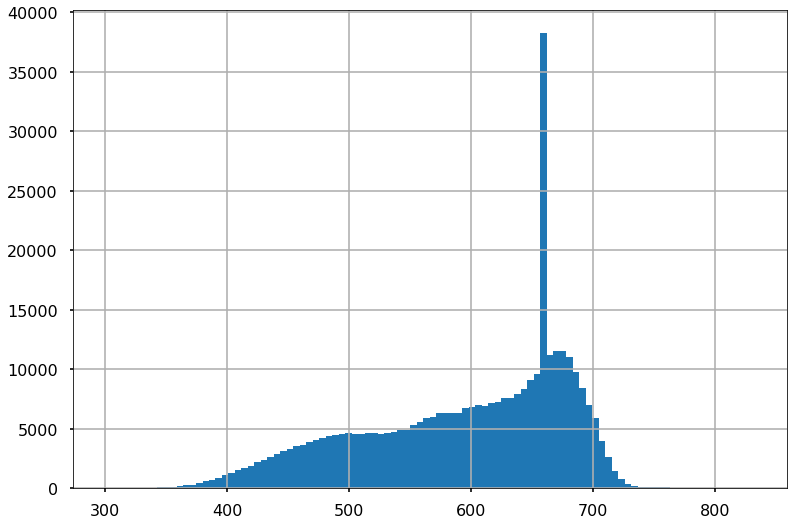

In [8]:
prod_df.model_score.hist(bins=100)

### Template
---

In [9]:
# get data
# prod_df = pkl.load(open('../../data/production-results/2020-08-05_full-customer-model-data.pickle', 'rb'))
prod_df = pkl.load(open('../../data-production/2020-09-01_full-customer-model-data.pickle', 'rb'))
prod_df['score'] = prod_df.model_score.astype(float)
prod_df['created_dt'] = pd.to_datetime(prod_df.created_dt)
prod_df = preprocess(prod_df)

modeling_df = pd.read_feather('../../data/combined_all_features/combined_1599599721.feather')
modeling_df = modeling_df[modeling_df.sample_date == pd.to_datetime('2020-08-31')]
modeling_df, _ = encode_defaults(modeling_df, default_values)
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']

In [10]:
# produce scores
model = pkl.load(open('../../models/customer_risk_target_from_gitlab.pkl', 'rb'))

In [11]:
modeling_df = preprocess(modeling_df)
modeling_df['pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['score'] = scale_scores(modeling_df['pred'])

In [12]:
# include active inactive accounts
active_accounts = modeling_df[(modeling_df.nr_past_transactions > 0) & (modeling_df.nr_transactions_30d > 0)].party_id.unique()
modeling_df['is_active'] = modeling_df.party_id.isin(active_accounts)
prod_df['is_active'] = prod_df.party_id.isin(active_accounts)

In [13]:
# pkl.dump(modeling_df, open('../../data-production/2020-08-31-customer-model-data-dev.pickle', 'wb'))

In [14]:
# trimming dfs
id_dict = get_overlap_and_diff(prod_df.party_id, modeling_df.party_id)
shared_id = id_dict['shared']
shared_cols = modeling_df.columns.intersection(prod_df.columns)
modeling_df = modeling_df[modeling_df.party_id.isin(shared_id)].drop_duplicates(subset='party_id')
prod_df = prod_df[prod_df.party_id.isin(shared_id)].drop_duplicates(subset='party_id')

In [15]:
# remove inactive accounts

modeling_df.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,indeterminate,sample_date,is_static,all7120_default_encoded,bcc7120_default_encoded,party_id,transaction_code_encoded,pred,score,is_active
957302,2019-06-17 18:01:13,44.0,410000434669,ACHDW,-10.09,1023025883,0.00,188,False,None,...,True,2020-08-31,True,-1.0,-1.0,188,5,0.003421,457.104096,False
957303,2020-08-28 18:01:12,247.0,410001046039,ACHDW,-3000.00,3225849957,389.27,774,False,None,...,True,2020-08-31,True,-1.0,-1.0,774,5,0.000347,386.500541,True
957304,2020-08-28 11:24:03,40.0,410000178332,DWATM,-177.75,,4892.95,195,False,None,...,True,2020-08-31,True,-1.0,-1.0,195,8,0.000676,407.051938,True
957305,2020-08-30 22:59:36,90.0,410001537288,DDTRF,220.00,,139721.13,273,False,None,...,True,2020-08-31,True,-1.0,-1.0,273,0,0.007243,480.335678,True
957306,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,True,2020-08-31,True,-1.0,-1.0,299,3,0.007125,479.822406,False


In [16]:
# # remove inactive accounts

# null_df = prod_df[prod_df.score == prod_df.score.value_counts().index[0]]
# null_accounts = null_df.party_id
# dormant_shared_ids = modeling_df.party_id.isin(null_accounts)
# modeling_df = modeling_df[~modeling_df.party_id.isin(dormant_shared_ids)].drop_duplicates(subset='party_id')
# prod_df = prod_df[~prod_df.party_id.isin(dormant_shared_ids)].drop_duplicates(subset='party_id')

#### Functionalities
---

In [17]:
combined_df = get_combined_dfs(modeling_df, prod_df, 'party_id')

((351135, 113), (351135, 55))

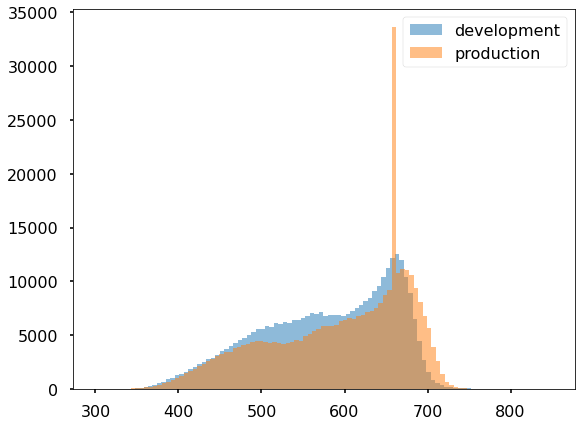

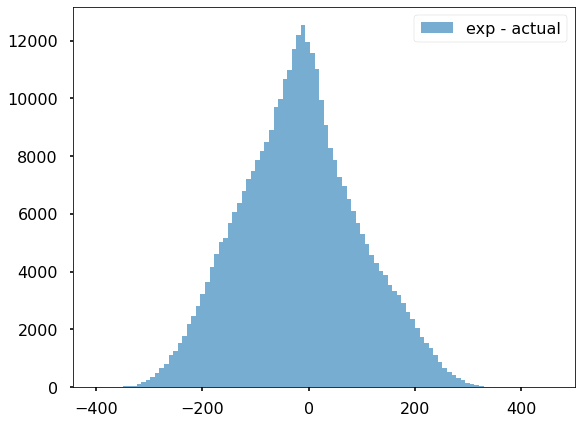

In [18]:
_ = plot_score_dist(modeling_df.score, prod_df.score, bins=100)
psi_df = get_psi(modeling_df[features], prod_df[features])

_ = plot_difference(modeling_df.score, prod_df.score, bins=100)
modeling_df.shape, prod_df.shape

In [19]:
psi_df.head(10)

,feature,psi
32,nr_trans_ratio,1.071267
9,giact_time_since_last_link,0.302687
6,transaction_as_pct_of_balance,0.112358
38,age_money_account,0.104129
27,time_since_last_transaction,0.098790
39,transaction_code_encoded,0.055040
10,name_address_correlation,0.053878
29,name_phone_correlation,0.053825
5,name_email_correlation,0.052726
33,iqt9413,0.046384


In [20]:
# report = get_feature_comparison_report(modeling_df, prod_df, 
#                                        'party_id', title='post-imp-report', 
#                                        cols=psi_df.head(6).feature.tolist(),
#                                        save_path='./feature-comparison-report')

### Look into troublesome features
---

In [21]:
# first filter out inactive accounts
modeling_df = modeling_df[modeling_df.is_active]
prod_df = prod_df[prod_df.is_active]

In [22]:
psi_df = get_psi(modeling_df[features], prod_df[features], buckets=2)
psi_df.head()

,feature,psi
9,giact_time_since_last_link,0.695403
32,nr_trans_ratio,0.354631
24,pct_returned_deposits,0.073706
16,nr_past_transactions,0.003072
27,time_since_last_transaction,0.002209


((84097, 113), (84097, 55))

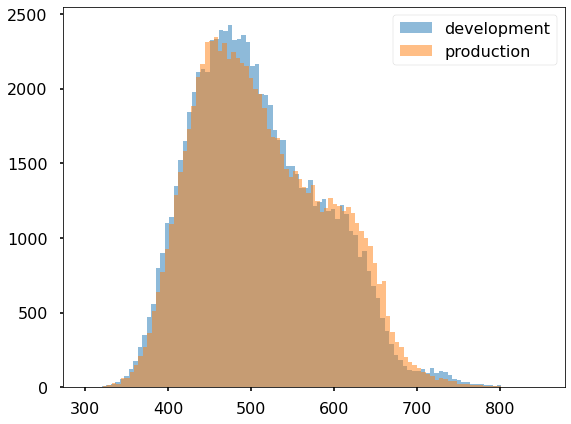

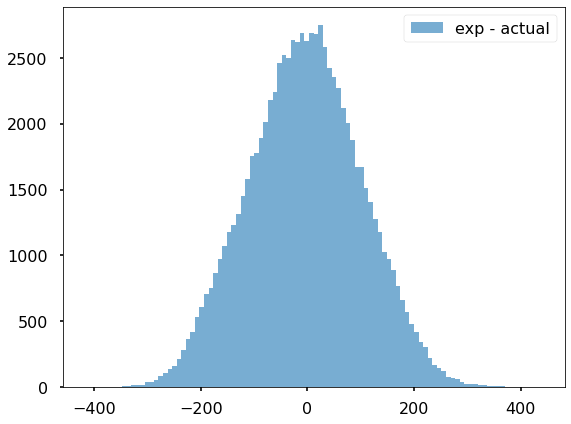

In [23]:
_ = plot_score_dist(modeling_df.score, prod_df.score, bins=100)
psi_df = get_psi(modeling_df[features], prod_df[features], buckets=2)

_ = plot_difference(modeling_df.score, prod_df.score, bins=100)
modeling_df.shape, prod_df.shape

In [29]:
len(active_accounts)

84309

In [23]:
psi_df.head()

,feature,psi
32,nr_trans_ratio,2.583664
9,giact_time_since_last_link,1.363008
24,pct_returned_deposits,0.119460
27,time_since_last_transaction,0.049876
26,nr_direct_deposits,0.017378


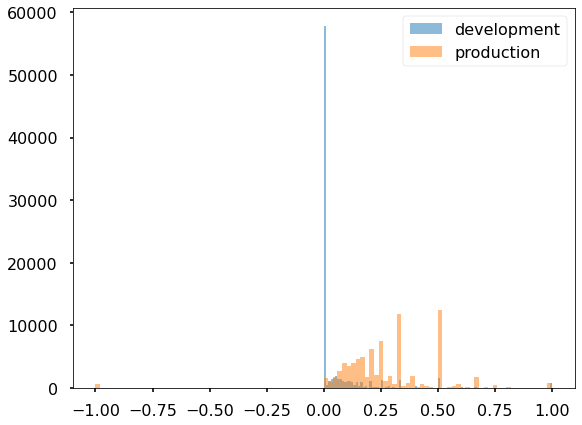

In [24]:
f = 'nr_trans_ratio'
_ = plot_score_dist(modeling_df[f], prod_df[f], bins=100)

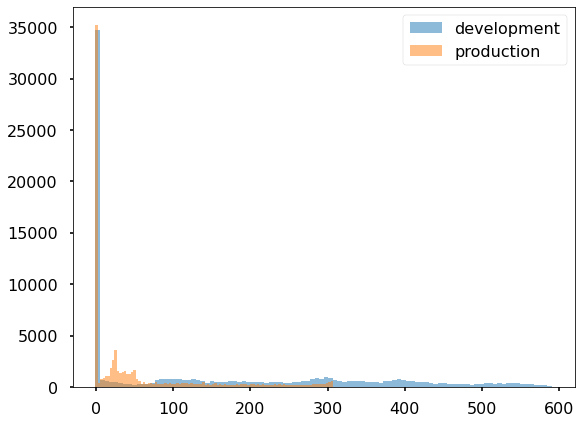

In [25]:
f = 'giact_time_since_last_link'
_ = plot_score_dist(modeling_df[f], prod_df[f], bins=100)

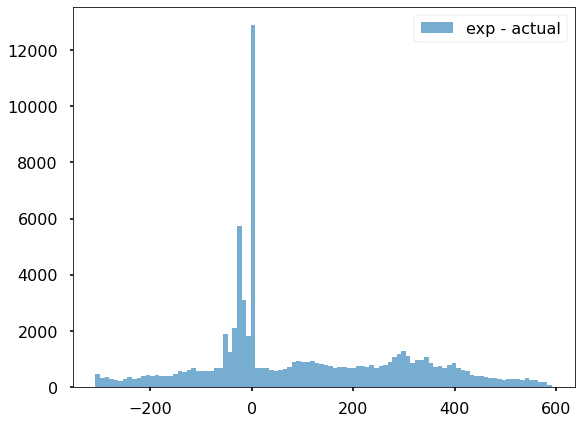

In [26]:
_ = plot_difference(modeling_df.giact_time_since_last_link, 
                    prod_df.giact_time_since_last_link, bins=100)

In [27]:
# grab party_id with most diff 'giact_time_since_last_link'

modeling_df.sort_values(by='party_id', inplace=True)
prod_df.sort_values(by='party_id', inplace=True)

In [28]:
debug_features = ['party_id', 'giact_time_since_last_link']
m_df = modeling_df[debug_features]
m_df.columns = ['party_id', 'dev_giact_time_since_last_link']
p_df = prod_df[debug_features]
p_df.columns = ['party_id', 'prod_giact_time_since_last_link']
debug_df = pd.merge(m_df, p_df, left_on='party_id', right_on='party_id')

In [29]:
debug_df['dev_default'] = debug_df.dev_giact_time_since_last_link == -1
debug_df['prod_default'] = debug_df.prod_giact_time_since_last_link == -1
debug_df['non_default'] = ~debug_df.dev_default & ~debug_df.prod_default
debug_df[['dev_default', 'prod_default']].value_counts()

dev_default  prod_default
False        False           28112
             True            22066
True         False           21112
             True            12807
dtype: int64

In [30]:
# sample from each groups
# T, F
# F, T
# T, T
np.random.seed(100)
debug_df['diff_giact_time'] = debug_df.dev_giact_time_since_last_link - debug_df.prod_giact_time_since_last_link
debug_df = debug_df[debug_df.diff_giact_time.abs() > 200].sample(10)
display(debug_df.sort_values(by='diff_giact_time', ascending=True))
giact_ids = debug_df.party_id.tolist()
print(giact_ids)

,party_id,dev_giact_time_since_last_link,prod_giact_time_since_last_link,dev_default,prod_default,non_default,diff_giact_time
44319,14869981,283.0,-1.0,False,True,False,284.0
37072,14353351,340.0,-1.0,False,True,False,341.0
16641,11783834,375.0,-1.0,False,True,False,376.0
28066,13744064,468.0,-1.0,False,True,False,469.0
14674,11051088,486.0,-1.0,False,True,False,487.0
22467,13253294,495.0,-1.0,False,True,False,496.0
19811,12951209,550.0,-1.0,False,True,False,551.0
11826,3755801,555.0,-1.0,False,True,False,556.0
5970,1402305,575.0,-1.0,False,True,False,576.0
3522,655384,584.0,-1.0,False,True,False,585.0


[11783834, 3755801, 1402305, 13253294, 14869981, 13744064, 655384, 12951209, 14353351, 11051088]


In [32]:
# report = get_feature_comparison_report(modeling_df, prod_df, 
#                                        'party_id', title='post-imp-report', 
#                                        cols=psi_df.head(3).feature.tolist(),
#                                        save_path='./feature-comparison-report-active-accts')

### Drill into Features
---
### giact_time_since_last_link

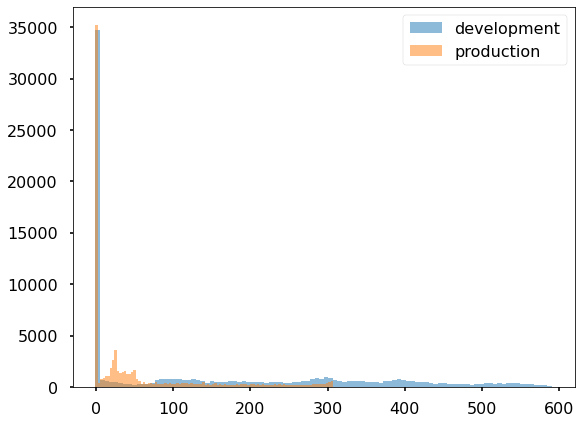

In [33]:
# first filter out inactive accounts
# modeling_df = modeling_df[modeling_df.is_active]
# prod_df = prod_df[prod_df.is_active]

f = 'giact_time_since_last_link'
_ = plot_score_dist(modeling_df[f], prod_df[f], bins=100)

In [52]:
giact_cols = modeling_df[features].columns[modeling_df[features].columns.str.contains('giact')]
giact_cols

Index(['giact_time_since_last_link', 'giact_nr_decline', 'giact_nr_other'], dtype='object')

In [60]:
# grab party_id with most diff 'giact_time_since_last_link'

modeling_df.sort_values(by='party_id', inplace=True)
prod_df.sort_values(by='party_id', inplace=True)

f = 'giact_time_since_last_link'
dev_f = f'dev_{f}'
prod_f = f'prod_{f}'
debug_features = ['party_id', f]
m_df = modeling_df[debug_features]
m_df.columns = ['party_id', dev_f]
p_df = prod_df[debug_features]
p_df.columns = ['party_id', prod_f]
debug_df = pd.merge(m_df, p_df, left_on='party_id', right_on='party_id')

debug_df['diff'] = debug_df[dev_f] - debug_df[prod_f]

debug_df['dev_default'] = debug_df[dev_f] == -1
debug_df['prod_default'] = debug_df[prod_f] == -1
debug_df['non_default'] = ~debug_df.dev_default & ~debug_df.prod_default
debug_df['is_close'] = (debug_df[dev_f] - debug_df[prod_f]).abs() < 1
debug_df[['dev_default', 'prod_default', 'is_close']].value_counts()

dev_default  prod_default  is_close
False        False         False       28096
             True          False       22066
True         False         False       21112
             True          True        12807
False        False         True           16
dtype: int64

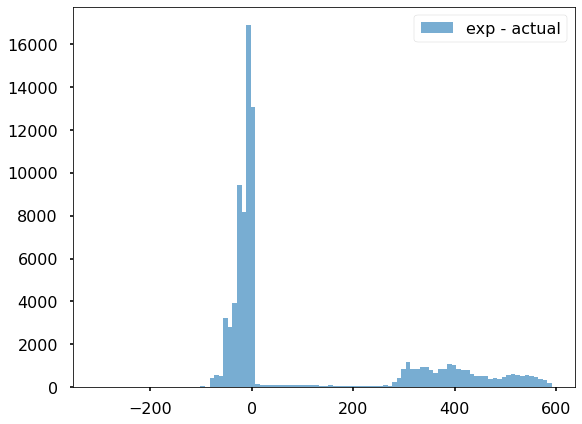

In [61]:
_ = plot_difference(modeling_df[f], 
                    prod_df[f], bins=100)

In [62]:
# sample from each groups
# T, F
# F, T
# T, T

for v1, v2 in [(True, False), (False, True), (False, False)]:
    print(f'dev_default: {v1}, prod_default: {v2}')
    np.random.seed(100)
    debug_df_ = debug_df[(debug_df.dev_default == v1) & (debug_df.prod_default == v2)]
    debug_df_['diff'] = debug_df_['diff'].abs()
    debug_df_ = debug_df_.sort_values(by='diff', ascending=False).head(100).sample(10)
    display(debug_df_)
    giact_ids = debug_df_.party_id.tolist()
    print(giact_ids)

dev_default: True, prod_default: False


,party_id,dev_giact_time_since_last_link,prod_giact_time_since_last_link,diff,dev_default,prod_default,non_default,is_close
18129,12355017,-1.0,99.0,100.0,True,False,False,False
15516,11384768,-1.0,86.0,87.0,True,False,False,False
581,68501,-1.0,104.0,105.0,True,False,False,False
21823,13216351,-1.0,98.0,99.0,True,False,False,False
13506,10542415,-1.0,100.0,101.0,True,False,False,False
10695,3311144,-1.0,105.0,106.0,True,False,False,False
16666,11792646,-1.0,99.0,100.0,True,False,False,False
36107,14292987,-1.0,102.0,103.0,True,False,False,False
15411,11341433,-1.0,82.0,83.0,True,False,False,False
2850,496398,-1.0,107.0,108.0,True,False,False,False


[12355017, 11384768, 68501, 13216351, 10542415, 3311144, 11792646, 14292987, 11341433, 496398]
dev_default: False, prod_default: True


,party_id,dev_giact_time_since_last_link,prod_giact_time_since_last_link,diff,dev_default,prod_default,non_default,is_close
20020,13013022,588.0,-1.0,589.0,False,True,False,False
398,46113,586.0,-1.0,587.0,False,True,False,False
14667,11048814,588.0,-1.0,589.0,False,True,False,False
8530,2424664,587.0,-1.0,588.0,False,True,False,False
20637,13100061,588.0,-1.0,589.0,False,True,False,False
1368,188296,588.0,-1.0,589.0,False,True,False,False
1774,258168,588.0,-1.0,589.0,False,True,False,False
8294,2315800,588.0,-1.0,589.0,False,True,False,False
12492,10149941,585.0,-1.0,586.0,False,True,False,False
6563,1612003,589.0,-1.0,590.0,False,True,False,False


[13013022, 46113, 11048814, 2424664, 13100061, 188296, 258168, 2315800, 10149941, 1612003]
dev_default: False, prod_default: False


,party_id,dev_giact_time_since_last_link,prod_giact_time_since_last_link,diff,dev_default,prod_default,non_default,is_close
21682,13205177,542.0,20.0,522.0,False,False,True,False
26318,13561222,510.0,2.0,508.0,False,False,True,False
23382,13312830,544.0,8.0,536.0,False,False,True,False
1979,295713,519.0,2.0,517.0,False,False,True,False
6923,1749468,568.0,44.0,524.0,False,False,True,False
5330,1180417,574.0,37.0,537.0,False,False,True,False
23251,13302051,543.0,20.0,523.0,False,False,True,False
1117,147650,529.0,2.0,527.0,False,False,True,False
25269,13473585,514.0,16.0,498.0,False,False,True,False
22064,13232272,541.0,2.0,539.0,False,False,True,False


[13205177, 13561222, 13312830, 295713, 1749468, 1180417, 13302051, 147650, 13473585, 13232272]


In [36]:
# not in dev, but in prod
debug_df[debug_df.party_id == 16297903]  

,party_id,dev_giact_time_since_last_link,prod_giact_time_since_last_link,diff,dev_default,prod_default,non_default,is_close
66594,16297903,-1.0,49.0,-50.0,True,False,False,False


In [37]:
# not in prod but in dev 
debug_df[debug_df.party_id == 13013022]  

,party_id,dev_giact_time_since_last_link,prod_giact_time_since_last_link,diff,dev_default,prod_default,non_default,is_close
20020,13013022,588.0,-1.0,589.0,False,True,False,False


In [38]:
# in both
debug_df[debug_df.party_id == 13205177]

,party_id,dev_giact_time_since_last_link,prod_giact_time_since_last_link,diff,dev_default,prod_default,non_default,is_close
21682,13205177,542.0,20.0,522.0,False,False,True,False


In [39]:
giact_FF = pd.read_csv('giact-data-F-F.csv')
giact_FT = pd.read_csv('giact-data-F-T.csv')
giact_TF = pd.read_csv('giact-data-T-F.csv')

In [40]:
import json


def get_giact_data(string, path):
    # convert string to json and get giact data
    data = json.loads(string)
    for p in path:
        data = data[p]
    return data

def get_giact_details(string, cell):
    try: 
        return get_giact_data(string, ['giactData', 'giactAccountDetails', 0, cell])
    except:
        return None

def get_giact_last_mod_date(string):
    return get_giact_data(string, ['giactData', 'lastModifiedDate'])



In [41]:
json.loads(giact_FF.cache[0])['giactData']['giactAccountDetails']

[{'@type': 'GiactAccountDetailsV3',
  'decisionDate': '2020-08-31T15:20:05.038876',
  'moneyAccountId': 410001482788,
  'linkedAccountId': '2186487274',
  'linkingDecision': 'PASS',
  'linkingResultId': '2ab12f8e-f48b-4fee-8e47-d6098842cfd2',
  'giactDetailsSource': {'@type': '.GiactDetailsSource$MoneyLinking',
   'linkingResultId': '2ab12f8e-f48b-4fee-8e47-d6098842cfd2'},
  'giactResponseCreatedDt': '2020-08-31T15:20:05.038876Z',
  'thirdPartyAuthResponseV2': {'customerName': 'JOE LEWIS',
   'thirdPartyId': '1f64b58f-496e-4582-8dec-88471d5fd8c9',
   'thirdPartyType': 'PLAID_INSTANT',
   'thirdPartyNames': ['Joseph Lewis'],
   'nameMatchingPercent': 100,
   'firstNameWasNormalized': True,
   'thirdPartyConnectionId': '916713a1-b4ad-44b4-a8a4-0479344be6d5',
   'externalNameMatchResult': 'MATCH',
   'internalNameMatchResult': 'EXACT'},
  'linkedAccountRoutingNumber': '124003116'}]

In [42]:
detail_cols = ['decisionDate', 'linkedAccountRoutingNumber', 'giactResponseCreatedDt']
for df in [giact_FF, giact_FT, giact_TF]:
    df['giactData'] = df.cache.apply(lambda x: json.loads(x)['giactData'])
    for col in detail_cols:
        df[col] = df.cache.apply(lambda x: get_giact_details(x, col))
    df['lastModifiedDate'] = df.cache.apply(get_giact_last_mod_date)

In [43]:
prod_giacts = {'giact_FF': giact_FF, 
               'giact_FT': giact_FT,
               'giact_TF': giact_TF}

In [44]:
giact_FF.head()

,dms_export_timestamp,money_cache_id,party_id,cache,created_by,created_dt,updated_by,updated_dt,giactData,decisionDate,linkedAccountRoutingNumber,giactResponseCreatedDt,lastModifiedDate
0,2020-09-08 04:19:28.219843,bf9ed869-2c00-42e8-b0fc-4550bcbe0ce8,13561222,"{""@type"": ""MoneyCacheData"", ""tmxData"": {""versi...",automation@sofi.org,2019-08-03 02:33:26.424,automation@sofi.org,2020-09-08 00:01:20.310,{'version': ''BdYkbaRD703boqpzHrNeTRfvii/CV2R7...,2020-08-31T15:20:05.038876,124003116,2020-08-31T15:20:05.038876Z,2020-08-31T15:20:05.057251Z
1,2020-09-08 04:17:45.878267,b8421ee7-e601-4ad5-9cfa-9ebcd93b2323,13205177,"{""@type"": ""MoneyCacheData"", ""tmxData"": {""versi...",automation@sofi.org,2019-08-02 22:07:44.409,automation@sofi.org,2020-09-08 00:03:47.459,{'version': ''BdYkbaRD703boqpzHrNeTRfvii/CV2R7...,2020-08-13T12:44:24.362591,091000022,2020-08-13T12:44:24.362591Z,2020-08-24T20:31:45.195926Z
2,2020-09-08 04:18:56.512192,745f7a01-7dbc-4849-ad4e-d5ac44edf07e,13232272,"{""@type"": ""MoneyCacheData"", ""tmxData"": {""versi...",automation@sofi.org,2019-08-02 22:24:44.577,automation@sofi.org,2020-09-08 00:01:14.806,{'version': ''BdYkbaRD703boqpzHrNeTRfvii/CV2R7...,2020-08-31T16:43:34.661739,044000804,2020-08-31T16:43:34.661739Z,2020-08-31T16:43:34.69844Z
3,2020-09-08 04:19:37.627642,176f272d-5e8f-4ead-9258-67ca3e41a62d,13302051,"{""@type"": ""MoneyCacheData"", ""tmxData"": {""versi...",automation@sofi.org,2019-08-02 21:58:12.838,automation@sofi.org,2020-09-08 00:01:52.979,{'version': ''BdYkbaRD703boqpzHrNeTRfvii/CV2R7...,2020-08-13T13:12:39.012907,121202211,2020-08-13T13:12:39.012907Z,2020-08-14T02:57:14.908678Z
4,2020-09-08 04:18:34.206363,8f20f236-0ed1-4d9e-bd03-32232dc341a4,1180417,"{""@type"": ""MoneyCacheData"", ""tmxData"": {""versi...",automation@sofi.org,2019-11-05 22:43:01.247,automation@sofi.org,2020-09-08 00:00:30.329,{'version': ''BdYkbaRD703boqpzHrNeTRfvii/CV2R7...,2020-07-27T14:31:02.488706,061000104,2020-07-27T14:31:02.488706Z,2020-07-27T14:31:02.503864Z


In [ ]:
modeling_giact = modeling_df[modeling_df.party_id.isin(giact_FF.party_id)]

Exception in thread Thread-45:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 558, in run
    self.terminate_broken(bpe)
  File "/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 736, in terminate_broken
    self.kill_workers()
  File "/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages